In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [47]:
path = 'dataset\lung-dataset\lung_image_sets'
classes = os.listdir(path)
classes


['lung_aca', 'lung_n', 'lung_scc']

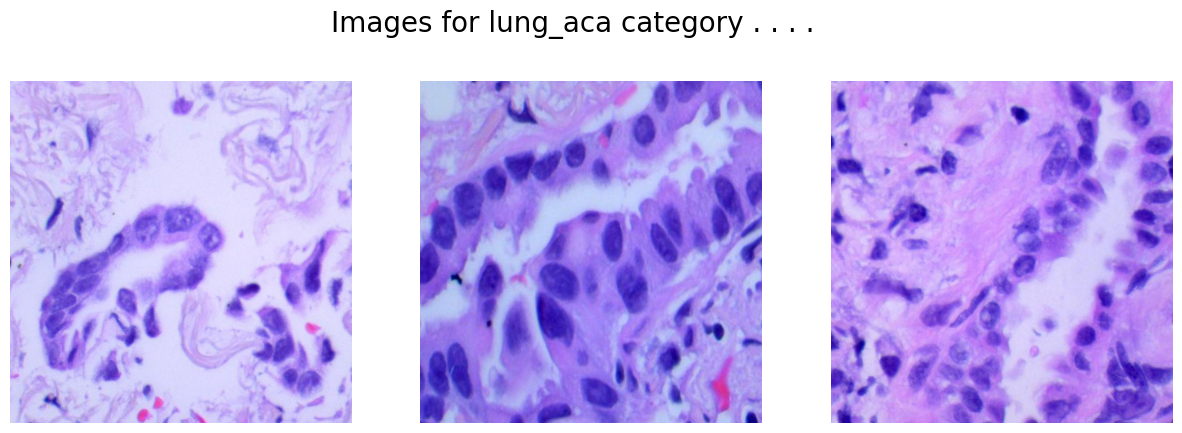

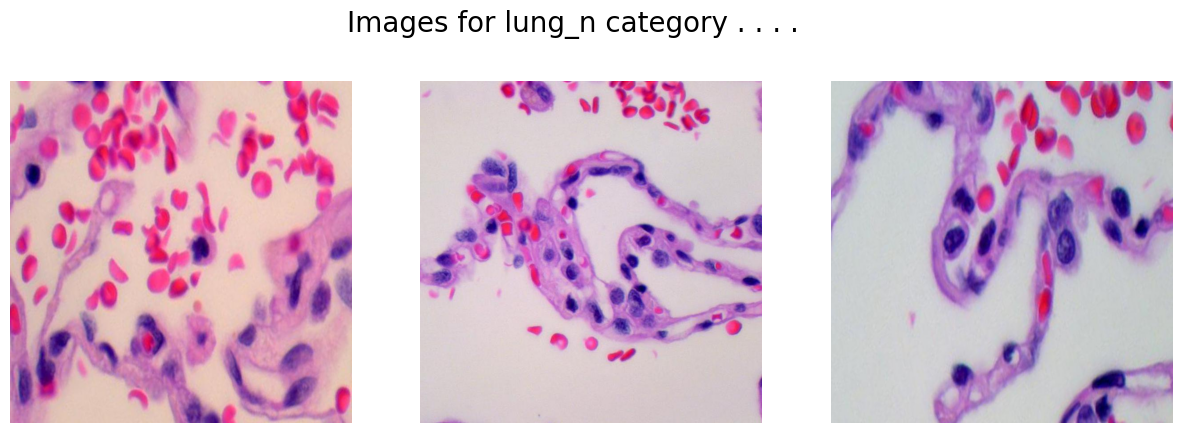

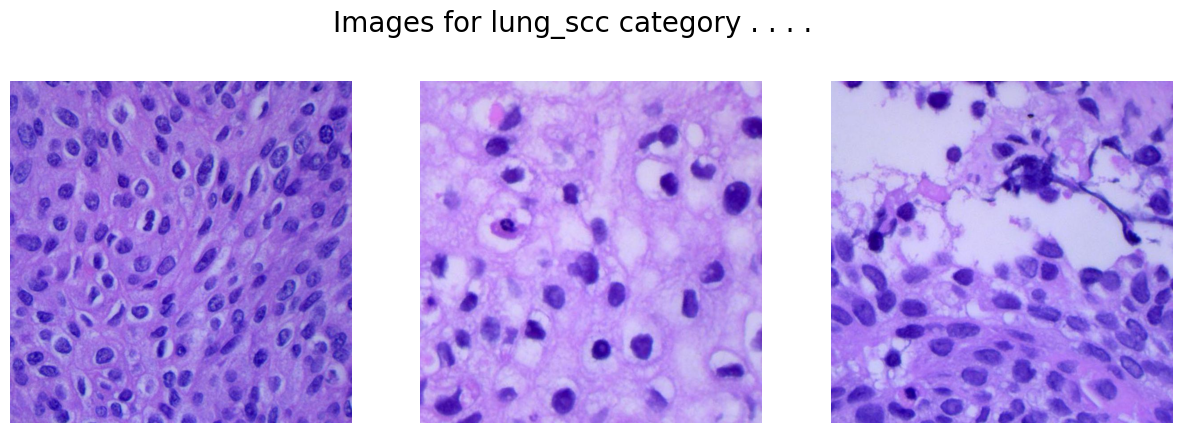

In [48]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', 
                 fontsize = 20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [49]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [50]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)
    
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [51]:
X_train, X_val, Y_train, Y_val = train_test_split(
  X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [56]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    weights = 'imagenet',
    include_top = False
)


In [57]:
len(pre_trained_model.layers)


311

In [58]:
for layer in pre_trained_model.layers:  
    layer.trainable = False  # Freeze earlier layers


In [59]:
last_layer = pre_trained_model.get_layer('mixed7')
output_shape = last_layer.input[0].shape 

print('last layer output shape: ', output_shape) 
last_output = last_layer.output

# This code is modified by Susobhan Akhuli


last layer output shape:  (None, 14, 14, 192)


In [60]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(3, activation='softmax')(x)  # Final output layer


In [61]:
model = keras.Model(pre_trained_model.input,output)

In [62]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [63]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 127, 127,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 125, 125,  │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 125, 125,  │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 62, 62,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 62, 62,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 60, 60,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 86,178,211 (328.74 MB)

 Trainable params: 77,202,947 (294.51 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [65]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.96:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)


In [67]:
checkpoint = ModelCheckpoint(
    'best_model_prediction_cancer.h5',  # File path to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,  # Print info when saving the model
    save_best_only=True,  # Save only the best model
    mode='max',  # Save the model with the maximum validation accuracy
)

In [68]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr,checkpoint, myCallback()])


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5133 - loss: 11.5650
Epoch 1: val_accuracy improved from -inf to 0.71900, saving model to best_model_prediction_cancer.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 831s 4s/step - accuracy: 0.5136 - loss: 11.5290 - val_accuracy: 0.7190 - val_loss: 0.6195 - learning_rate: 1.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6358 - loss: 0.8064
Epoch 2: val_accuracy did not improve from 0.71900
188/188 ━━━━━━━━━━━━━━━━━━━━ 818s 4s/step - accuracy: 0.6359 - loss: 0.8063 - val_accuracy: 0.7093 - val_loss: 0.5663 - learning_rate: 1.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6822 - loss: 0.7421
Epoch 3: val_accuracy improved from 0.71900 to 0.75033, saving model to best_model_prediction_cancer.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 1261s 7s/step - accuracy: 0.6822 - loss: 0.7421 - val_accuracy: 0.7503 - val_loss: 0.5991 - learning_rate: 1.0000e-05
Epoch 4/10
126/188 ━━━━━━━━━━━━━━━━━━━━ 6:27 6s/step - accuracy: 0.6939 - loss: 0.7142

KeyboardInterrupt: 

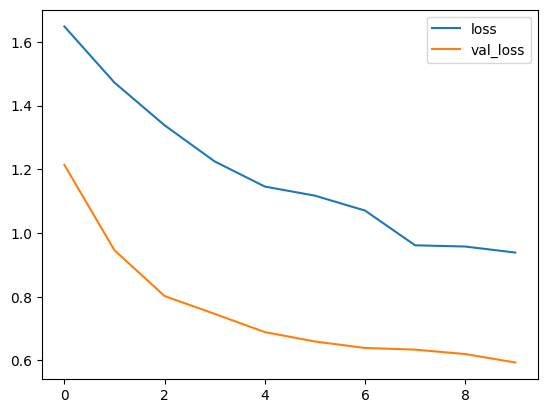

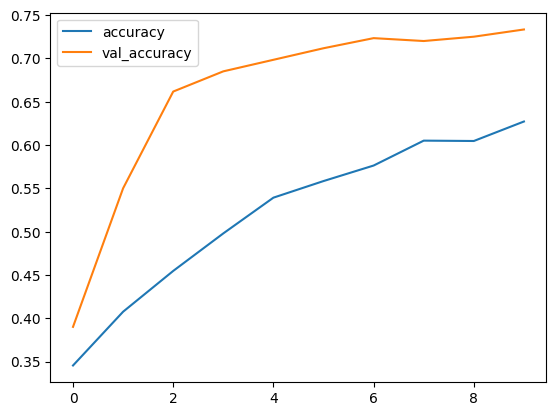

In [42]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [43]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


In [44]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[ 71,  63,  73],
       [  5, 189,   1],
       [ 13,   5, 180]])

In [45]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.80      0.34      0.48       207
      lung_n       0.74      0.97      0.84       195
    lung_scc       0.71      0.91      0.80       198

    accuracy                           0.73       600
   macro avg       0.75      0.74      0.70       600
weighted avg       0.75      0.73      0.70       600

